In [1]:
import pandas as pd
import numpy as np

import os
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def set_seed(seed_value=0):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed()

In [3]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid") 

In [4]:
SOURCE_DATA_DIR = '../data/raw/ml-100k'
DEST_DATA_DIR = '../data/internal'
BENCHMARK_DATA_DIR = '../benchmark/data'

In [5]:
df_data = pd.read_csv(os.path.join(SOURCE_DATA_DIR, 'u.data'), sep='\t', header=None)
df_data.columns = columns = ['user_id', 'item_id', 'rating', 'timestamp']

In [6]:
df_data.timestamp = df_data.timestamp // 60 // 60 // 24 # Convert seconds to days

In [7]:
df_data.head(5)

,user_id,item_id,rating,timestamp
0,196,242,3,10199
1,186,302,3,10320
2,22,377,1,10172
3,244,51,2,10192
4,166,346,1,10259


In [8]:
df_item = pd.read_csv(os.path.join(SOURCE_DATA_DIR, 'u.item'), sep='|', encoding = "ISO-8859-1", header=None)
genre_columns = ["unknown", "action", "adventure", "animation", "children", "comedy", "crime", "documentary", "drama", "fantasy", "film_noir", "horror", "musical", "mystery", "romance", "sci_fi", "thriller", "war", "western"]
df_item.columns = ["movie_id", "movie_title", "release_date", "video_release_date", "imdb_url"] + genre_columns
df_item = df_item.drop(columns=['video_release_date'])

In [9]:
df_item['release_date'] = pd.to_datetime(df_item['release_date'])
df_item['release_date'] = df_item['release_date'].astype('int64') // 10**9 // 60 // 60 // 24  # Convert nanoseconds to days

In [10]:
if df_item.movie_id.is_unique:
    df_item = df_item.set_index('movie_id')

In [11]:
df_item = df_item.drop(columns=['movie_title', 'imdb_url'])

In [12]:
df_item.head(5)

,release_date,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
movie_id,,,,,,,,,,,,,,,,,,,,
1,9131,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9131,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,9131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,9131,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,9131,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [13]:
df_user = pd.read_csv(os.path.join(SOURCE_DATA_DIR, 'u.user'), sep='|', header=None)
df_user.columns = ["user_id", "age", "gender", "occupation", "zip_code"]

In [14]:
label_encoder = LabelEncoder()
df_user['gender_encoded'] = label_encoder.fit_transform(df_user['gender'])

In [15]:
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
occupation_encoded = onehot_encoder.fit_transform(df_user[['occupation']]).astype(int)
occupation_encoded_df = pd.DataFrame(occupation_encoded, columns=onehot_encoder.get_feature_names_out(['occupation']))
df_user = pd.concat([df_user, occupation_encoded_df], axis=1)
df_user[occupation_encoded_df.columns] = df_user[occupation_encoded_df.columns]

In [16]:
if df_user.user_id.is_unique:
    df_user = df_user.set_index('user_id')

In [17]:
df_user = df_user.drop(columns=['occupation', 'gender', 'zip_code'])

In [18]:
df_user.head(5)

,age,gender_encoded,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,occupation_healthcare,occupation_homemaker,occupation_lawyer,occupation_librarian,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
user_id,,,,,,,,,,,,,,,,,,,,,,
1,24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,53,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,33,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


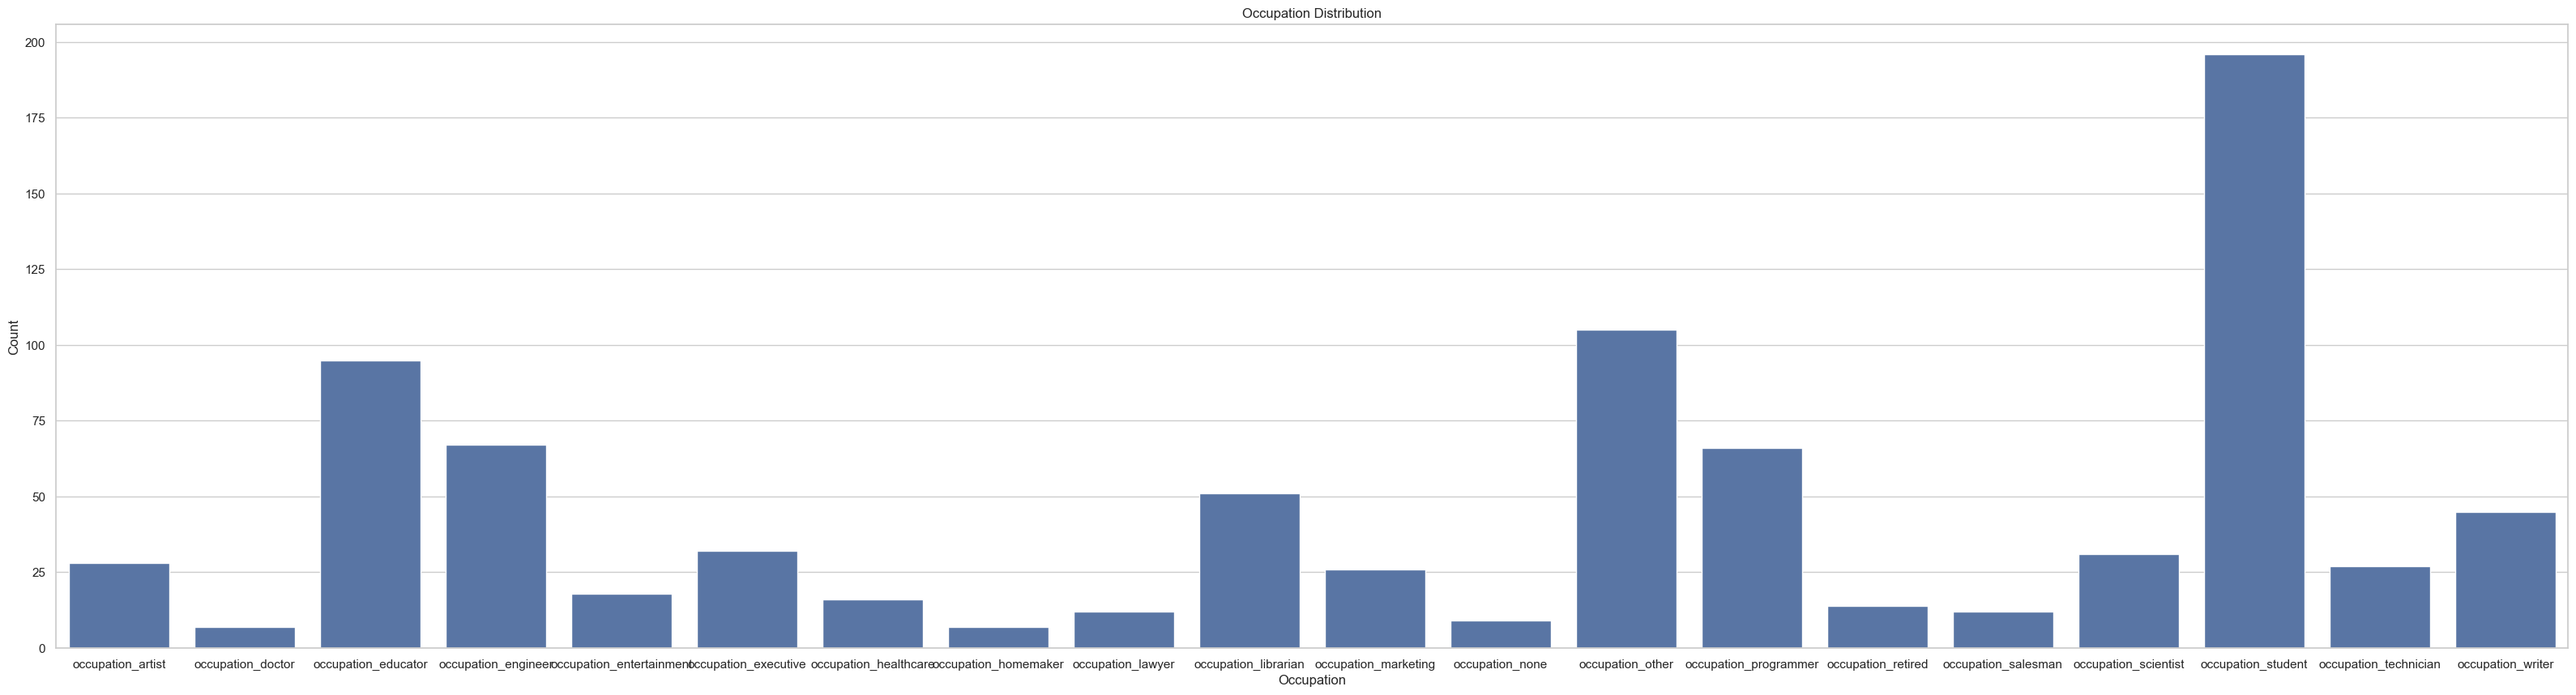

In [19]:
occupation_counts = df_user[occupation_encoded_df.columns].sum()
plt.figure(figsize=(40, 10))
sns.barplot(x=occupation_counts.index, y=occupation_counts.values)
plt.title('Occupation Distribution')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.show()

In [20]:
print('Amount of doctors:\t\t\t', df_user.occupation_doctor.sum())
print('Amount of homemakers: \t\t\t', df_user.occupation_homemaker.sum())
print('Amount of people with no occupation:\t', df_user.occupation_none.sum())

Amount of doctors:			 7
Amount of homemakers: 			 7
Amount of people with no occupation:	 9


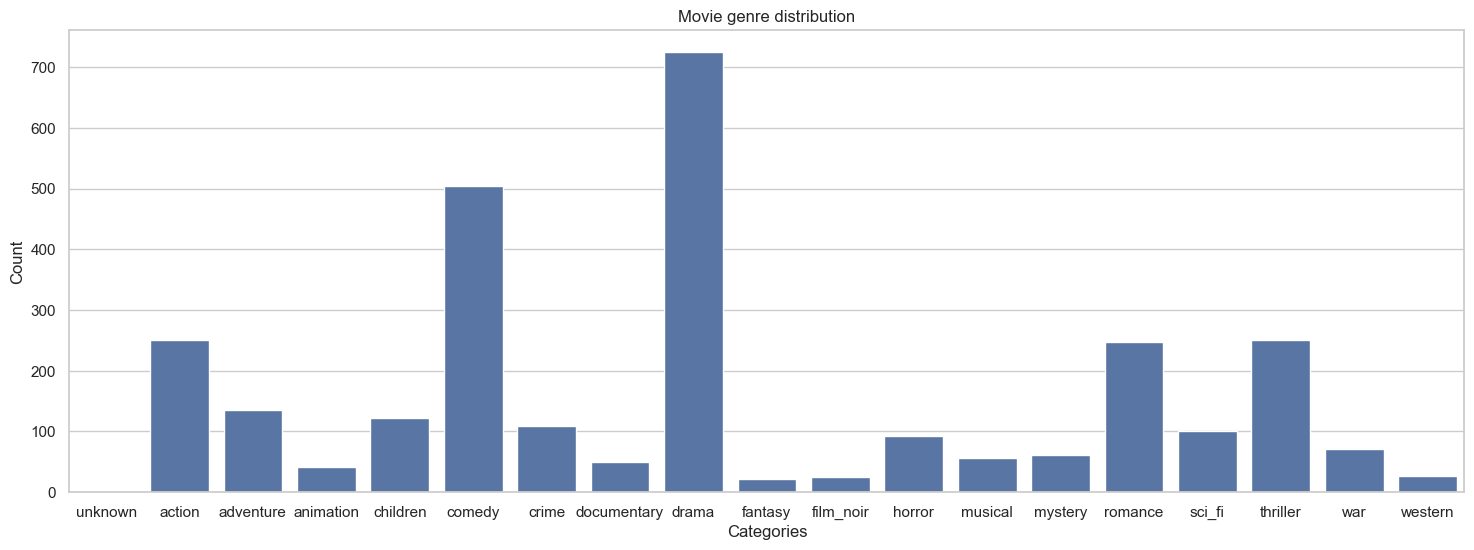

In [21]:
category_counts = df_item[genre_columns].sum()
plt.figure(figsize=(18, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Movie genre distribution')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [22]:
print('Amount of films with unknown genre:\t', df_item.unknown.sum())
print('Amount of fantasy films: \t\t', df_item.fantasy.sum())
print('Amount of film-noir films: \t\t', df_item.film_noir.sum())

Amount of films with unknown genre:	 2
Amount of fantasy films: 		 22
Amount of film-noir films: 		 24


In [23]:
df_item[df_item.unknown == 1]

,release_date,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
movie_id,,,,,,,,,,,,,,,,,,,,
267,-106752,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1373,399,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
df_item = df_item[df_item.unknown != 1].drop(columns=['unknown'])

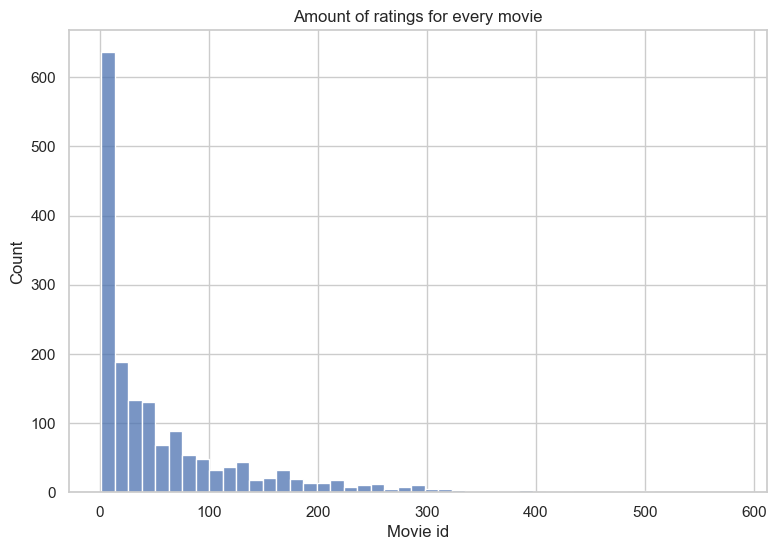

In [25]:
plt.figure(figsize=(9, 6))
sns.histplot(df_data.item_id.value_counts())

plt.title('Amount of ratings for every movie')
plt.xlabel('Movie id')
plt.ylabel('Count')
plt.show()

In [26]:
movie_count_filter = df_data.item_id.value_counts() >= 30
print(f'There are {df_item.shape[0] - movie_count_filter.sum()} outlier films')

There are 874 outlier films


In [27]:
df_data = df_data[df_data.item_id.isin(movie_count_filter[movie_count_filter == True].index)]

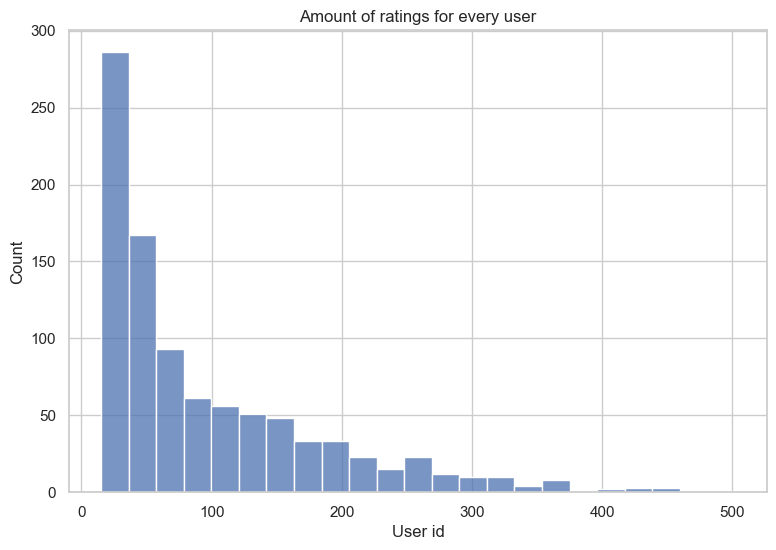

In [28]:
plt.figure(figsize=(9, 6))
sns.histplot(df_data.user_id.value_counts())

plt.title('Amount of ratings for every user')
plt.xlabel('User id')
plt.ylabel('Count')
plt.show()

In [29]:
user_count_filter = df_data.user_id.value_counts() >= 30
print(f'There are {df_user.shape[0] - user_count_filter.sum()} outlier users')

There are 220 outlier users


In [30]:
df_data = df_data[df_data.user_id.isin(user_count_filter[user_count_filter == True].index)]

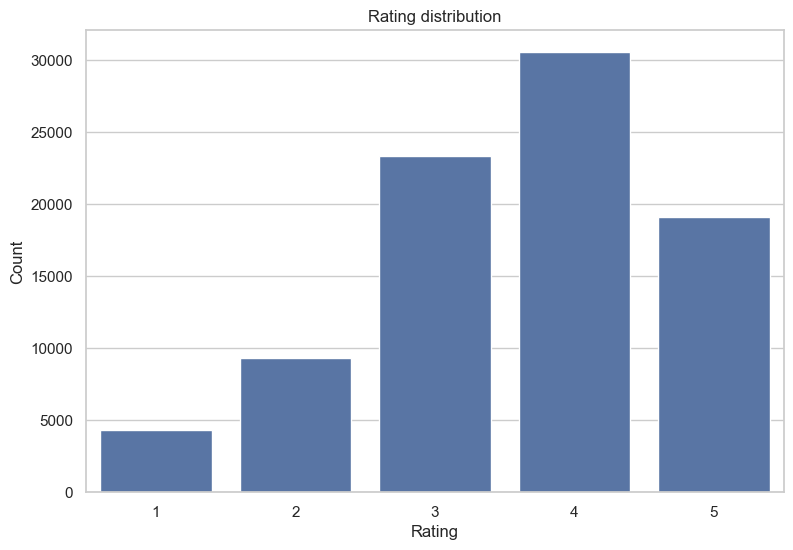

In [31]:
plt.figure(figsize=(9, 6))
sns.barplot(df_data['rating'].value_counts().sort_index())
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

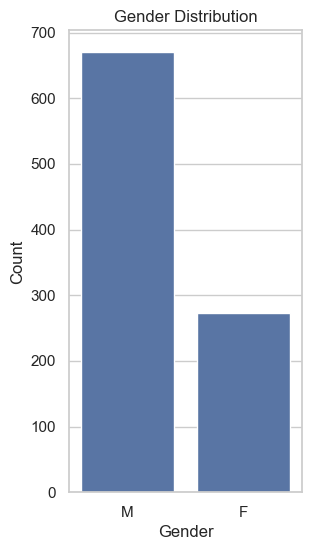

In [32]:
plt.figure(figsize=(3, 6))
sns.barplot(y=df_user['gender_encoded'].value_counts(), x=['M', 'F'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

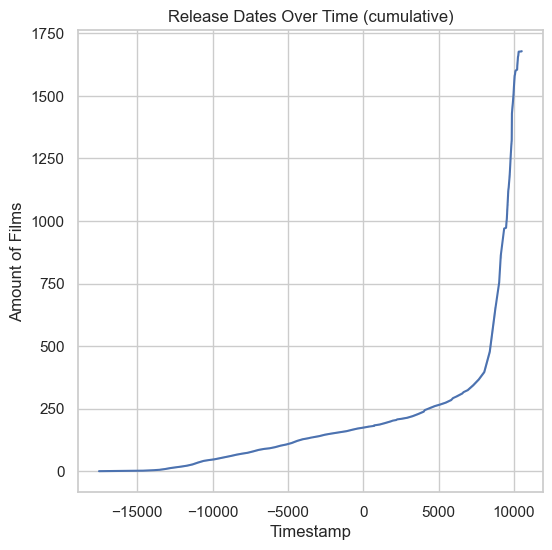

In [33]:
plt.figure(figsize=(6, 6)) 
sns.lineplot(x=df_item.release_date.sort_values().values, y=range(len(df_item)))

plt.title('Release Dates Over Time (cumulative)')
plt.xlabel('Timestamp')
plt.ylabel('Amount of Films')

plt.show()

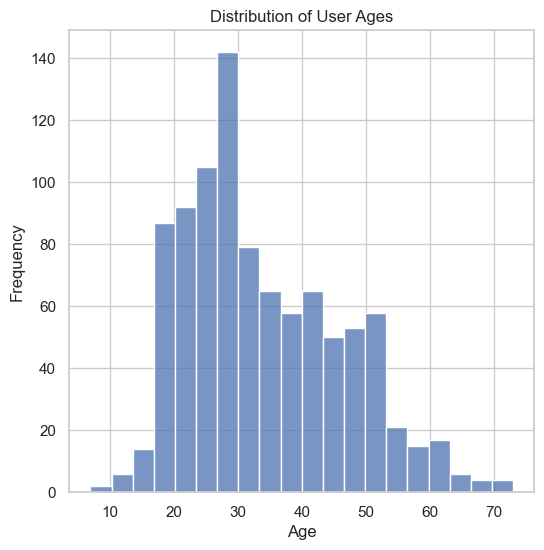

In [34]:
plt.figure(figsize=(6, 6)) 
sns.histplot(df_user.age, bins=20, kde=False)

plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()

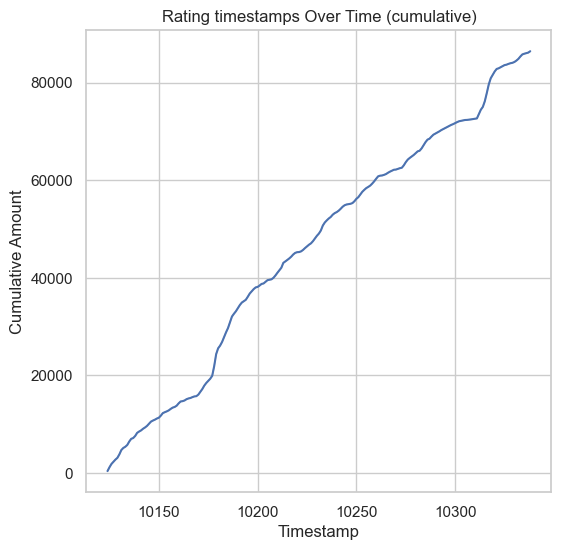

In [35]:
plt.figure(figsize=(6, 6)) 
sns.lineplot(x=df_data.timestamp.sort_values().values, y=range(len(df_data)))

plt.title('Rating timestamps Over Time (cumulative)')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Amount')

plt.show()

In [36]:
release_date_mean = df_item.release_date.mean()
release_date_std = df_item.release_date.std()
release_date_filter = ((release_date_mean - release_date_std * 3) <= df_item.release_date) & (df_item.release_date <= (release_date_mean + release_date_std * 3))
print(f'There are {df_item.shape[0] - release_date_filter.sum()} outlier films')

There are 64 outlier films


In [37]:
df_item = df_item[release_date_filter]

In [38]:
age_mean = df_user.age.mean()
age_std = df_user.age.std()
age_filter = ((age_mean - age_std * 3) <= df_user.age) & (df_user.age <= (age_mean + age_std * 3))
print(f'There are {df_user.shape[0] - age_filter.sum()} outlier users')

There are 1 outlier users


In [39]:
df_user = df_user[age_filter]

In [40]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_data['timestamp'].values.reshape(-1, 1))
df_data["timestamp"] = scaled_data

In [41]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_item['release_date'].values.reshape(-1, 1))
df_item["release_date"] = scaled_data

In [42]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_user['age'].values.reshape(-1, 1))
df_user["age"] = scaled_data

In [43]:
df_data = df_data[df_data.item_id.isin(df_item.index) & df_data.user_id.isin(df_user.index)]
df_data.shape

(83441, 4)

In [44]:
df_user = df_user[df_user.index.isin(df_data.user_id)]
df_user.shape

(722, 22)

In [45]:
df_item = df_item[df_item.index.isin(df_data.item_id)]
df_item.shape

(773, 19)

In [46]:
label_encoder_user = LabelEncoder()
label_encoder_movie = LabelEncoder()
df_user['original_user_id'] = df_user.index
df_item['original_item_id'] = df_item.index
df_user.index = label_encoder_user.fit_transform(df_user.index.values)
df_item.index = label_encoder_movie.fit_transform(df_item.index.values)
df_data.user_id = label_encoder_user.transform(df_data.user_id.values)
df_data.item_id = label_encoder_movie.transform(df_data.item_id.values)

In [47]:
df_user.to_csv(os.path.join(DEST_DATA_DIR, 'user.csv'))
df_item.to_csv(os.path.join(DEST_DATA_DIR, 'item.csv'))

In [48]:
df_data_train, df_data_val_test = train_test_split(df_data, test_size=0.2, stratify=df_data.item_id)
df_data_val, df_data_test = train_test_split(df_data_val_test, test_size=0.5, stratify=df_data_val_test.item_id)

In [49]:
df_data_train.to_csv(os.path.join(DEST_DATA_DIR, 'data_train.csv'), index=False)
df_data_val.to_csv(os.path.join(DEST_DATA_DIR, 'data_val.csv'), index=False)
df_data_test.to_csv(os.path.join(BENCHMARK_DATA_DIR, 'data_test.csv'), index=False)